# Taylor neural networks to learn nuisance parametrization

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:",device)

import sys
sys.path.insert(1, './utils/')
import PLOTutils as plot
import TAYLORutils as taylor

Device: cpu


## Overview
We consider the 1D toy model analyzed in https://arxiv.org/abs/2111.13633 :

$$n(x|{\rm R}_{\nu_S})=n({\rm R_0})\exp[-x e^{-\nu_S}-\nu_S]$$

and we focus on the problem of learning the shape distortion within the scale uncertainty ($\nu_S$) using a quadratic polynomial approximation:
$$\log(r(x|\nu_S))= \log \left[\frac{n(x|{\rm R}_{\nu_S})}{n(x|{\rm R}_{0})}\right] \approx \nu_S \widehat\delta_1(x) + \nu_S^2 \widehat\delta_2(x)$$

The code in this notebook aims to estimate $\widehat\delta_{1,2}(x)$ as neural networks

## 1) Prepare Data

we need multiple datasets generated according to multiple values of $\nu_S$:

In [13]:
nu_list = np.array([-0.3, -0.05, 0.05, 0.3])
nu_std = np.around(np.std(nu_list), 2)
nu_mean = np.mean(nu_list)
nu_list_std = (nu_list-nu_mean)/nu_std
print("Standard deviation of nu:", nu_std)
print("Standardized values of nu:", nu_list_std)

Standard deviation of nu: 0.21505813167606566
Standardized values of nu: [-1.39497166 -0.23249528  0.23249528  1.39497166]


for each value of $\nu_i$ we want to generate both a transformed sample $S_{\nu_i}$ and a reference sample $S_0$:

In [14]:
N=40000 # training points per dataset
mean  = 1/8.
X = np.concatenate([np.random.exponential(scale=mean, size=(N, 1)) for _ in range(len(nu_list))] + 
                   [np.random.exponential(scale=mean*np.exp(nu_list[i]), size=(N, 1)) for i in range(len(nu_list))], 
                   axis=0)

#standardize
X = X / mean

we use labels to distinguish transformed and reference samples:

In [15]:
Y_labels = np.concatenate([np.zeros(N) for _ in range(len(nu_list))]+
                          [np.ones(N) for _ in range(len(nu_list))],
                          axis=0)


and we store the information about the 

In [16]:
Y_nu = np.concatenate([np.full(N,nu_list_std[i]) for i in range(len(nu_list))]+
                      [np.full(N,nu_list_std[i]) for i in range(len(nu_list))])
Y = np.column_stack([Y_labels, Y_nu])

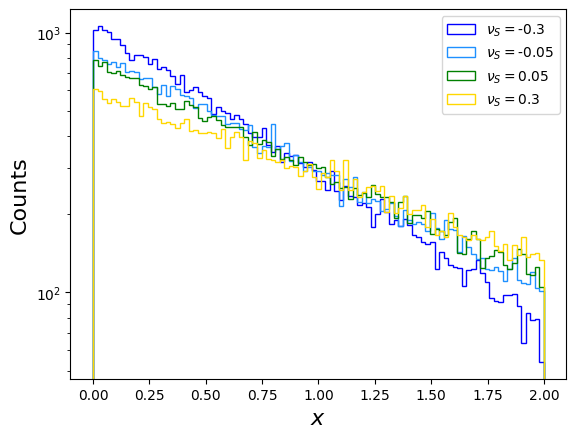

In [17]:
bins = np.linspace(0, 2, 100)
colors = ['blue', 'dodgerblue', 'green', 'gold']
for i, nu in enumerate(nu_list_std):
    mask = (Y[:, 0] == 1) & (Y[:, 1] == nu)
    plt.hist(X[mask], histtype='step', bins=bins, label=r'$\nu_S=$'+str(nu_list[i]), color=colors[i])
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel(r'$x$', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.show()

## 2) Training

In [18]:
# parameters of the training
batch_size_ = 1000
polyn_degree_=2
epochs_ = 1000
patience_ = 10
learning_rate_ = 1e-3
input_dim_ = X.shape[1]
hidden_layers_ = (10,)
clip_=1

# Create data loaders
train_ds = TensorDataset(torch.tensor(X, dtype=torch.float32),
                         torch.tensor(Y, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=batch_size_, shuffle=True, num_workers=4)

# Initialize model
model = taylor.PolynomialModel(input_dim_, polyn_degree=polyn_degree_, hidden_layers=hidden_layers_, clip=clip_).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate_)

epoch_losses = []

In [19]:
# Train
for epoch in range(epochs_):
    running_loss = 0
    optimizer.zero_grad()
    for xb, yb in train_loader:

        xb, yb = xb.to(device), yb.to(device)
        nv = yb[:, 1:2]  # shape (B, 1)

        pred = model(xb, nv)
        loss = model.loss(pred, yb)        
        running_loss += loss 

    avg_loss = running_loss / len(train_loader)
    avg_loss.backward()

    # Now apply the optimizer, after accumulating/finding the average loss from all batches
    optimizer.step()
    model.clip_weights()
    epoch_losses.append(avg_loss)
    if not epoch%patience_:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 66.7657
Epoch 11, Loss: 43.6621
Epoch 21, Loss: 29.1007
Epoch 31, Loss: 19.8298
Epoch 41, Loss: 13.6983
Epoch 51, Loss: 9.3732
Epoch 61, Loss: 6.1057
Epoch 71, Loss: 3.4855
Epoch 81, Loss: 1.2897
Epoch 91, Loss: -0.6041
Epoch 101, Loss: -2.2631
Epoch 111, Loss: -3.7252
Epoch 121, Loss: -5.0087
Epoch 131, Loss: -6.1258
Epoch 141, Loss: -7.0872
Epoch 151, Loss: -7.9002
Epoch 161, Loss: -8.5760
Epoch 171, Loss: -9.1281
Epoch 181, Loss: -9.5725
Epoch 191, Loss: -9.9257
Epoch 201, Loss: -10.2012
Epoch 211, Loss: -10.4141
Epoch 221, Loss: -10.5793
Epoch 231, Loss: -10.7087
Epoch 241, Loss: -10.8110
Epoch 251, Loss: -10.8919
Epoch 261, Loss: -10.9585
Epoch 271, Loss: -11.0142
Epoch 281, Loss: -11.0613
Epoch 291, Loss: -11.1021
Epoch 301, Loss: -11.1379
Epoch 311, Loss: -11.1691
Epoch 321, Loss: -11.1970
Epoch 331, Loss: -11.2220
Epoch 341, Loss: -11.2443
Epoch 351, Loss: -11.2643
Epoch 361, Loss: -11.2828
Epoch 371, Loss: -11.2999
Epoch 381, Loss: -11.3160
Epoch 391, Loss: -11.

In [20]:
# save model state 
hidden_layers_string = "-".join(map(str, hidden_layers_))
torch.save(model.state_dict(), './PolynModel_hiddenlayers%s_nustd%s_deg%i_epoch%i.pth'%(hidden_layers_string, str(nu_std), polyn_degree_, len(epoch_losses)))

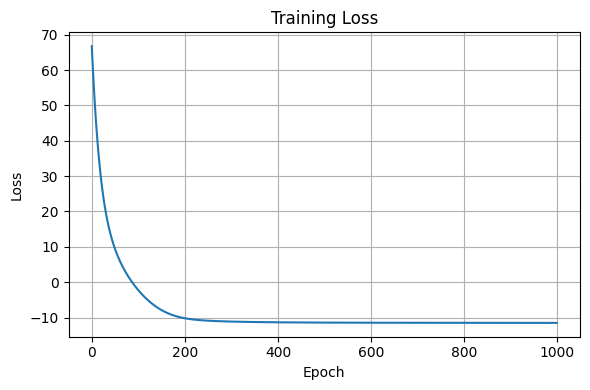

In [26]:
# plot loss history
plot.plot_loss_curves(epoch_losses)

## 3) Visual check of reconsruction quality

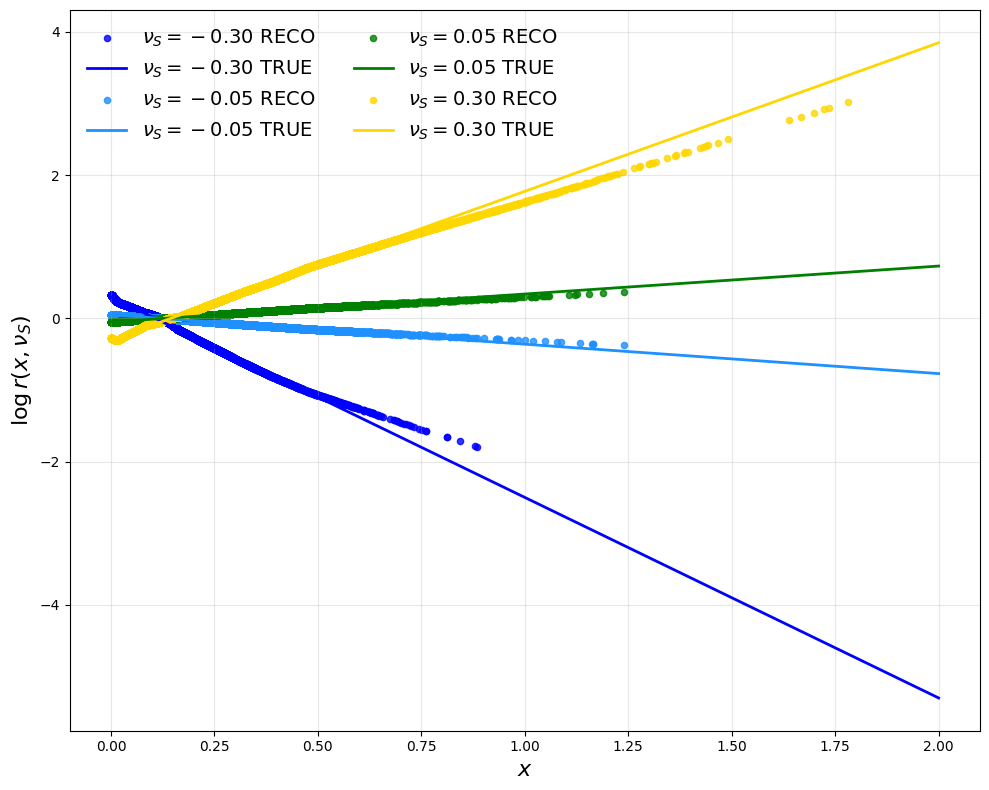

In [27]:
# plot reconstruction vs. true log(r)

# --- Configuration ---
colors = ['blue', 'dodgerblue', 'green', 'gold']
feature = X
target = Y
nuisance = target[:, 1]   # assume nuisance is 1D here
nu_values = np.unique(nuisance)

# --- Model evaluation ---
with torch.no_grad():
    delta = model(
        torch.from_numpy(feature).float(),
        torch.from_numpy(target).float()[:, 1:2]
    ).cpu().numpy()

# --- Plot ---
plt.figure(figsize=(10, 8))

for i, nu in enumerate(nu_list_std):
    mask = (target[:, 0] == 1) & (nuisance == nu)

    plt.scatter(
        feature[mask]*mean, # remove standardization (get the orginal scale back)
        delta[mask],
        s=20,
        color=colors[i % len(colors)],
        label=rf'$\nu_S = {nu_list[i]:.2f}$ RECO',
        alpha=0.8
    )

    x = np.linspace(0, 2, 100)
    #y = x*(1-np.exp(-1*nu_list[i]))-nu_list[i]
    y = np.log(np.exp(-1*nu_list[i])/mean*np.exp(-1./mean*x*np.exp(-1*nu_list[i])) ) - np.log(1./mean*np.exp(-1./mean*x))
    plt.plot(x, y, color=colors[i], lw=2, label=rf'$\nu_S = {nu_list[i]:.2f}$ TRUE',)

plt.xlabel(r'$x$', fontsize=16)
plt.ylabel(r'$\log r(x,\nu_S)$', fontsize=16)
plt.legend(fontsize=14, frameon=False, ncol=2)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()
